# Welcome to this notebook! We provide you with the code needed to generate the results and graphs shown in our original paper. Please follow the guidelines and steps mentioned below to ensure smooth get your results.

## Table of Contents:

1. [Load Libraries](#Load-Libraries)
2. [Load Datasets](#Load-Datasets)
3. [Time Series Plot of Original Data](#Time-Series-Plot-of-Original-Data)
4. [Data Processing](#Data-Processing)
   - [Remove Gaps (Filter Data)](#Remove-Gaps-(Filter-Data))
   - [Time Series Plot of Filter Data](#Time-Series-Plot-of-Filter-Data)
5. [Stationary Test](#Stationary-Test)
6. [Log Kernel Density Plot](#Log-Kernel-Density-Plot)
7. [Bimodality](#Bimodality)
8. [Increment Frequency](#Increment-Frequency)
9. [Autocorrelation Plot](#Autocorrelation-Plot)
10. [Linearity](#Linearity)
11. [Detrended Fluctuation Analysis](#Detrended-Fluctuation-Analysis)
12. [Chapman-Kolmogorov (CK) test](#Chapman-Kolmogorov-(CK)-test)
13. [Rescaled Range Analysis (R/S)](#Rescaled-Range-Analysis-(R/S))

**Note:** Starting from Section 5, all results and analyses are generated using the `filtered_data` obtained in Section 4. However, if you wish to perform analyses using the original dataset, make sure to add the code: `filtered_data = dataframes` before proceeding to Section 5

Now, let's dive into the sections step by step.

<a id='Load-Libraries'></a>
## Load Libraries
Import the necessary libraries and modules required for data analysis, visualization, and processing.

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import diptest
from numpy import random

from scipy.stats import skew, kurtosis
from scipy.optimize import curve_fit

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf

import plotly.express as px
import plotly.io as pio

from MFDFA import MFDFA
from MFDFA import fgn

from hurst import compute_Hc, random_walk

<a id='Load-Datasets'></a>
## Load Datasets
Load the datasets you want to analysis, here we power-grid frequency data colleced from Australia and Singapore. The datasets are in 1-hour intervals with a resolution of one second. The second column is frequency. Below is the code to load the datasets:

In [2]:
# The 'Data' folder is within the current directory where your Jupyter notebook is
folder_path = os.path.join(os.getcwd(), 'Data')

# The other way to load your data is to define the base folder path
#folder_path = 'C:/1.1 Asia frequency data'

# Select the datasets you want to analysis
selected_files = ['ASI01_AUS01_1H.csv', 'ASI01_SGP01_1H.csv']

dataframes = []

for file_name in selected_files:
    # Construct the full file path using os.path.join
    file_path = os.path.join(folder_path, file_name)
    
    # Read the file into a dataframe
    df = pd.read_csv(file_path, sep=',')
    
    # Modify the second column by dividing by 1000 and adding 50
    df.iloc[:, 1] = df.iloc[:, 1] / 1000 + 50
    
    # Append the processed dataframe to the list
    dataframes.append(df)

# Please change your region_dic based on the regions you load
region_dict = {0: 'Australia', 1: 'Singapore'}

<a id='Time Series Plot of Original Data'></a>
## Time Series Plot of Original Data
We will start by creating time series plots for the power-grid frequency data.

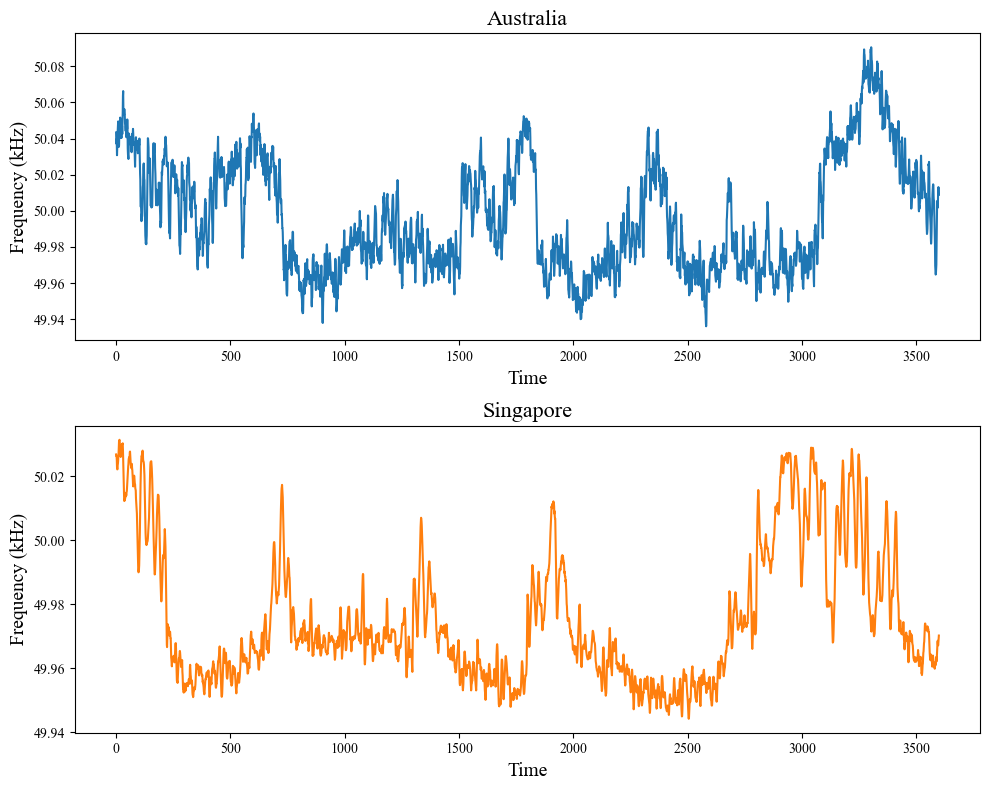

In [4]:
# Use a colormap to generate colors based on the number of datasets
cmap = plt.get_cmap('tab10')  # 'tab10' is a colormap suitable for discrete categories; adjust if needed
colors = [cmap(i) for i in range(len(dataframes))]

# Create subplots for each filtered dataframe
# Set the overall figure size to 10 inches wide by 8 inches tall.
fig, axs = plt.subplots(nrows=len(dataframes), figsize=(10,8))

# Plot each filtered dataframe with a distinct color
for i, df in enumerate(dataframes):
    axs[i].plot(df['f50'], color=colors[i])  # Set the color from the generated colors list
    axs[i].set_title(region_dict[i], fontsize=16)
    axs[i].set_xlabel('Time', fontsize=14)
    axs[i].set_ylabel('Frequency (kHz)', fontsize=14)

# Update the font used in the plot to 'Times New Roman'.
plt.rcParams.update({'font.family': 'Times New Roman'})
# Adjust the layout of the figure so that there's no overlap between subplots.
plt.tight_layout()
plt.show()

<a id='Data Processing'></a>
## Data Processing

<a id='Remove Gaps (Filter Data)'></a>
### Remove Gaps (Filter Data)
In this section, we will perform data filtering to retain the longest continuous part of the time series data for each region.

In [5]:
# Find the longest continuous part for each region
filter_data = []
for df in dataframes:
    # Convert the 'Time' column to datetime type
    df['Time'] = pd.to_datetime(df['Time'])
    time_diff = df['Time'].diff()

    # Find the longest continuous part by grouping consecutive timestamps with the same difference
    groups = (time_diff != pd.Timedelta(seconds=1)).cumsum()
    max_group = groups.value_counts().idxmax()

    # Filter the DataFrame to retain only the longest continuous part
    longest_continuous_df = df[groups == max_group]
    filter_data.append(longest_continuous_df)

filter_dict = {0: 'Australia', 1: 'Singapore'}

<a id='Time Series Plot of Filter Data'></a>
### Time Series Plot of Filter Data
Create time series plots for `filtered_data`.

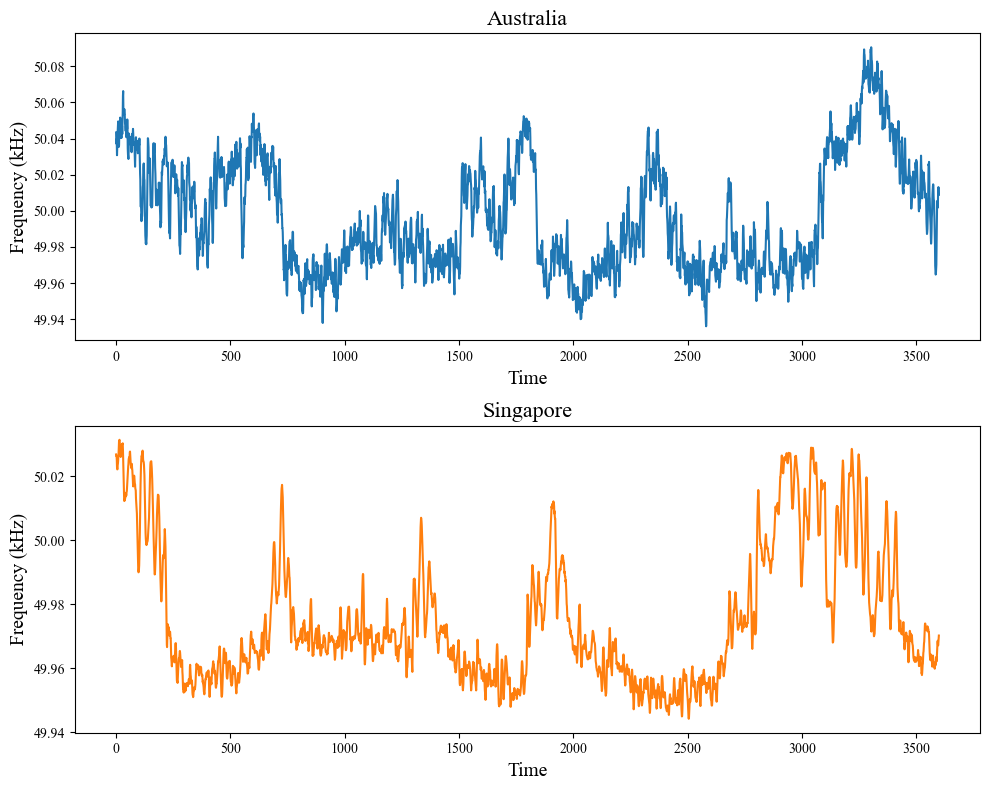

In [6]:
fig, axs = plt.subplots(nrows=len(filter_data), figsize=(10,8))

# Iterate over each dataframe in `filter_data` and its index.
for i, df in enumerate(filter_data):
    axs[i].plot(df['f50'],color=colors[i])
    axs[i].set_title(filter_dict[i], fontsize=16)
    axs[i].set_xlabel('Time', fontsize=14)
    axs[i].set_ylabel('Frequency (kHz)',fontsize=14)

# Update the font used in the plot to 'Times New Roman'.
plt.rcParams.update({'font.family': 'Times New Roman'})

# Adjust the layout of the figure so that there's no overlap between subplots.
plt.tight_layout()

# Display the figure.
plt.show()


<a id='Stationary Test'></a>
## Stationary Test
We assess the stationarity of `filtered_data` using the KPSS (Kwiatkowski–Phillips–Schmidt–Shin) test. This tests for a null hypothesis where a time series is stationary, compared to the alternative hypothesis of a unit root indicating non-stationarity.

In [7]:
for i, df in enumerate(filter_data):
    data = df.iloc[:, 1].dropna().values
    result = kpss(data, regression="c", nlags=0)
    test_statistic = result[0]
    p_value = result[1]

    # Assuming a 5% significance level
    critical_value_5percent = result[3]['5%']

    if test_statistic > critical_value_5percent:
        print(f"Region {filter_dict[i]}: Test Statistic = {test_statistic:.4f}, p-value = {p_value:.4f} (Non-Stationary)")
    else:
        print(f"Region {filter_dict[i]}: Test Statistic = {test_statistic:.4f}, p-value = {p_value:.4f} (Stationary)")


Region Australia: Test Statistic = 25.4215, p-value = 0.0100 (Non-Stationary)
Region Singapore: Test Statistic = 28.2225, p-value = 0.0100 (Non-Stationary)


C:\Users\wp7528\AppData\Local\Temp\ipykernel_16300\3529887331.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(data, regression="c", nlags=0)
C:\Users\wp7528\AppData\Local\Temp\ipykernel_16300\3529887331.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(data, regression="c", nlags=0)


<a id='Log-Kernel-Density-Plot'></a>
## Log Kernel Density Plot
Create a log kernel density plot, we set the logarithmic scale on the y-axis.

Region Australia - Skewness: 0.54, Kurtosis: 2.41
Region Singapore - Skewness: 0.99, Kurtosis: 2.99


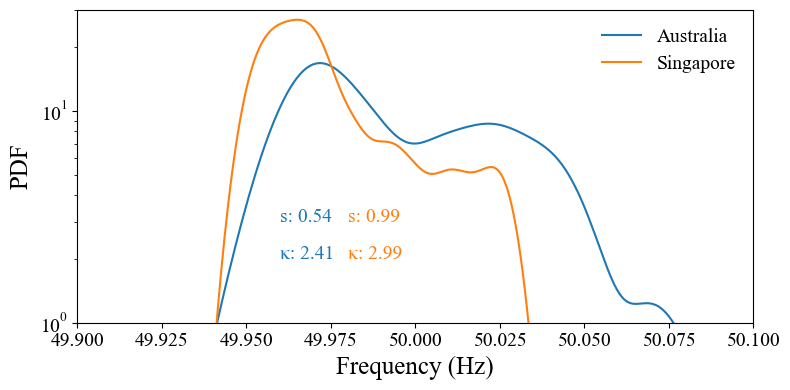

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))

for i, df in enumerate(filter_data):
    data = df['f50']
    # Use Seaborn's kdeplot for plotting Kernel Density Estimation
    sns.kdeplot(data, color=colors[i], ax=ax, label=filter_dict[i])
    
# Compute skewness and kurtosis for each dataset's 'f50'
# Appending results to respective lists
skewness = []
kurtosis = []

for df in filter_data:
    skewness.append(df['f50'].skew())           
    kurtosis.append(df['f50'].kurtosis() + 3)   

#ax.set_title('Asia-Australia', fontsize=12)
ax.set_xlabel('Frequency (Hz)', fontsize=18)
ax.set_ylabel('PDF', fontsize=18)
ax.set_yscale('log') 
ax.set_xlim([49.9, 50.1])
ax.set_ylim([1, 30])
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

# Convert skewness and kurtosis lists to numpy arrays for vectorized operations
s = np.array(skewness)
k = np.array(kurtosis)

# Annotate the plot with skewness and kurtosis values, adjusting position for clarity
for i, (skew_val, kurt_val) in enumerate(zip(s, k)):
    ax.text(49.96+i*0.02, 3, f's: {skew_val.item():.2f}', color=colors[i], fontsize=14)
    ax.text(49.96+i*0.02, 2, f'\u03ba: {kurt_val.item():.2f}', color=colors[i], fontsize=14)

plt.legend(fontsize=14, loc='upper right', frameon=False)

# Print skewness and kurtosis for each region
for i, (skew_val, kurt_val) in enumerate(zip(s, k)):
    print(f"Region {filter_dict[i]} - Skewness: {skew_val:.2f}, Kurtosis: {kurt_val:.2f}")

plt.tight_layout()
plt.show()

<a id='Bimodality'></a>
## Bimodality
we calculate the dip statistic, which is a measure of the degree of bimodality, or equivalently, the deviation from unimodality. This statistic quantifies the distance between the empirical distribution and the closest unimodal distribution, with larger values indicating a greater departure from unimodality

[('Australia', 0.01090142701257466), ('Singapore', 0.005134117068646328)]


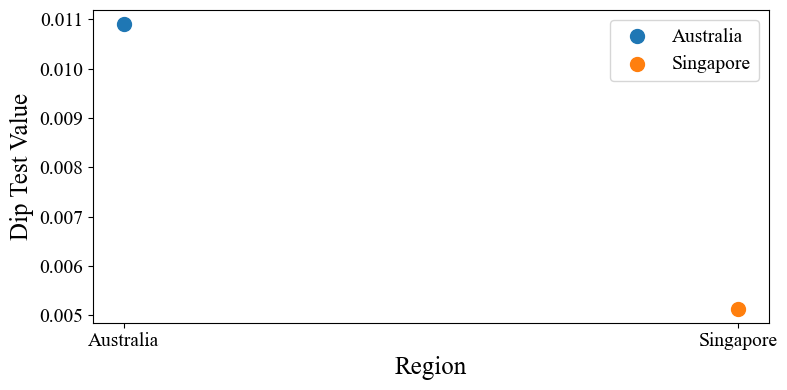

In [9]:
dips = []
for i, df in enumerate (filter_data):
    # Perform Dip Test on the 'f50' column after ensuring it's of float type
    dip,pval = diptest.diptest(df['f50'].astype(float))
    region = filter_dict[i]
    dips.append((region, dip))
print(dips)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Scatter plot of Dip Test values with markers and colors
for i, (region, dip) in enumerate(dips):
    ax.scatter(i, dip, color=colors[i], marker='o', s=100, label=region)

ax.set_xticks(range(len(dips)))
ax.set_xticklabels([region for region, _ in dips])
ax.set_ylabel('Dip Test Value', fontsize=18)
ax.set_xlabel('Region', fontsize=18)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.legend(fontsize=14)

plt.tight_layout()
plt.show()

<a id='Increment-Frequency'></a>
## Increment Frequency
To calculate the frequency increment ∆fτ, we will follow the formula ∆fτ = f(t+τ) − f(t), where τ = 1 second. Next, we will create a kernel density plot of the calculated frequency increments and add the skewness and kurtosis values to the plot.

Region: Australia, Skewness: 0.04797476572662559, Kurtosis: 3.3171224610939776
Region: Singapore, Skewness: 0.033677976112441776, Kurtosis: 4.572162260530342


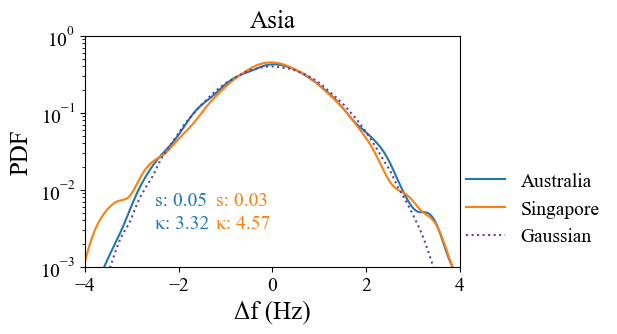

In [10]:
tau = 1

fig, ax = plt.subplots(figsize=(6, 3))

# Calculate increment frequency and drop NA values
increment_dfs = []

for i, df in enumerate(filter_data):
    df_copy = df.copy()
    df_copy['increment_freq'] = df_copy.iloc[:, 1].diff(periods=tau)
    increment_data = df_copy.dropna().copy()  # Create a copy to avoid SettingWithCopyWarning
    
    # Normalize the increment frequency column to have mean 0 and standard deviation 1
    mean = increment_data['increment_freq'].mean()
    std = increment_data['increment_freq'].std()
    increment_data['normalized_increment_freq'] = (increment_data['increment_freq'] - mean) / std
    
    increment_dfs.append(increment_data)

skewness = []
kurtosis = []

for df in increment_dfs:
    skewness.append(df['normalized_increment_freq'].skew())
    kurtosis.append(df['normalized_increment_freq'].kurtosis() + 3)

# Plot the filtered data inside the loop
for i, df in enumerate(increment_dfs):
    sns.kdeplot(df['normalized_increment_freq'], color=colors[i], ax=ax, label=filter_dict[i])

# Plot normal distribution curve
sns.kdeplot(random.normal(loc=0, scale=1, size=200000), color='#6a3d9a', ax=ax, label='Gaussian', linestyle=":")

ax.set_title('Asia', fontsize=18)
ax.set_xlabel('Δf (Hz)', fontsize=18)
ax.set_ylabel('PDF', fontsize=18)
ax.set_yscale('log')

ax.set_xlim([-4,4])
ax.set_ylim([1e-3, 1])

ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

# Add skewness and kurtosis annotations
s = skewness  
k = kurtosis 

for i, (skew_val, kurt_val) in enumerate(zip(s, k)):
    ax.text(-2.5+i*1.3, 10**-2.2, f's: {skew_val.item():.2f}', color=colors[i], fontsize=14)
    ax.text(-2.5+i*1.3, 10**-2.5, f'\u03ba: {kurt_val.item():.2f}', color=colors[i], fontsize=14)

plt.legend(fontsize=14, bbox_to_anchor=(1.42, 0.25), loc='center right', frameon=False)

# Adjust subplot spacing
plt.subplots_adjust(right=0.75)

# Print region name, skewness, and kurtosis values
for i, region in enumerate(filter_dict):
    print(f"Region: {filter_dict[i]}, Skewness: {skewness[i]}, Kurtosis: {kurtosis[i]}")

plt.rcParams.update({'font.family': 'Times New Roman'})
plt.show()

<a id='Autocorrelation-Plot'></a>
## Autocorrelation Plot
Next, we delve into understanding the autocorrelation of the frequency time series. To visually represent the autocorrelation and the exponential decay process, we create plots that showcase the ACF values and the fitted exponential decay curves. For each region, we display the ACF curve and overlay the corresponding exponential decay curve, marked with the decay constant (λ) value.

The main plot illustrates the ACF and exponential decay for a longer lag period, while an inset plot provides a closer look at the ACF and decay for a shorter lag. The x-axis of both plots is labeled in minutes.

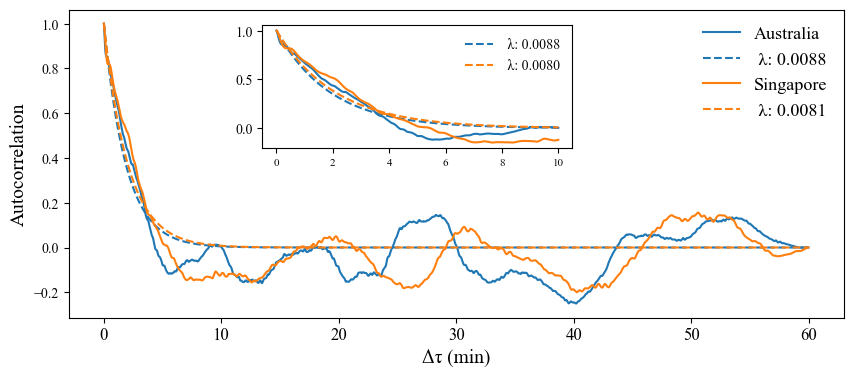

In [38]:
# Define the exponential decay function
def exp_decay(t, lamb):
    return np.exp(-lamb * t)

asia_lambda = []
asia_lambda_inset = []

fig, ax = plt.subplots(figsize=(10, 4))

# Create an inset inside the main ax
axins = ax.inset_axes([0.25, 0.55, 0.40, 0.40]) # [x, y, width, height] of the inset

# Assuming filter_data is a list of dataframes where each dataframe contains data for a region
for i, df in enumerate(filter_data):
    data = df.iloc[:, 1]
    acf_vals = acf(data, nlags=3600*1) # Thia is for the main plot
    acf_vals_inset = acf(data, nlags=600) # This is for the inset
    
    t_values = np.arange(len(acf_vals))
    t_values_inset = np.arange(len(acf_vals_inset))
    
    # Use curve_fit to fit the acf values to the exp_decay function
    popt, _ = curve_fit(exp_decay, t_values, acf_vals, p0=(0.001))
    popt_inset, _ = curve_fit(exp_decay, t_values_inset, acf_vals_inset, p0=(0.001))
    
    lambdas = popt[0]
    asia_lambda.append(lambdas)
    lambda_inset = popt_inset[0] # For the inset
    asia_lambda_inset.append(lambda_inset)
    
    ax.plot(acf_vals, color=colors[i], label=f"{filter_dict[i]}")
    ax.plot(exp_decay(t_values, *popt), linestyle='--', 
            color=colors[i], label=f" λ: {lambdas:.4f}")
    
    # Plot on the inset
    axins.plot(acf_vals_inset, color=colors[i])
    axins.plot(exp_decay(t_values_inset, *popt_inset), linestyle='--', 
               color=colors[i], label=f" λ: {lambda_inset:.4f}")

# Set properties of the main plot
ax.set_xlabel('Δτ (min)', fontsize=14)
ax.set_ylabel('Autocorrelation', fontsize=14)
ticks = np.arange(0, 3600*1+1, 600) # Every 10 minutes (600 seconds)
tick_labels = [f'{i//60}' for i in ticks]
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels, fontsize=12)
ax.legend(fontsize=13, loc='upper right', frameon=False)

# Set properties of the inset
#axins.set_title('First 3600 lags')
axins.set_xticks(np.arange(0, 601, 120)) # Every 2 minutes which is 120 seconds
axins.set_xticklabels(['0', '2', '4', '6', '8', '10'], fontsize=8)
axins.legend(fontsize=10, loc='upper right', frameon=False)

plt.show()

<a id='Linearity'></a>
## Linearity

We use the higher-order autocorrelation function to test the linearity of the power-grid frequency data by quantifying the correlation between two observations in a time series at a given time lag. In addition, we compare the original data to a surrogate time series. To get surrogate time series, we take the Fourier transform (FT) of the original data and randomizing the phases before using an inverse FT to obtain the surrogate data. This procedure eliminate any non-linearity in the process, resulting in surrogate data that solely reflects the linear characteristics of the analyzed data.

Next, we calculate the root mean square error (RMSE) between them. If the value of RMSE is close to zero, it indicates that
the time series exhibits linear behavior.

Finally, we create a Scatter plot of rmse values.

In [25]:
def linear_test (data):
    
    # input: a time series data
    # output: root mean square value between original data and surrogate time series
    
    # Compute Fourier transform 
    fft_0 = np.fft.fft(data)
    
    # Randomize phases of Fourier coefficients
    rand_phases = np.random.uniform(0, 2*np.pi, size=len(fft_0))
    surrogate = np.abs(fft_0) * np.exp(1j * rand_phases)
    
    # Compute inverse Fourier transform to obtain surrogate data
    # surrogate data only includes linear characteristics
    surrogate = np.real(np.fft.ifft(surrogate))
    
    # Remove NaN values from the data, get the length of the data
    data = data[~np.isnan(data)]
    L = len(data)
    
    # Define the time lags (tau)
    tau = np.arange(1, 1800, 60)
    
    # Initialize arrays to store results
    res_2 = np.zeros(len(tau))
    surr_2 = np.zeros(len(tau))
    
    # Calculate moments for different time lags
    for i in range(len(tau)):
        x_t = data[0 :L-tau[i]]
        x_tau = data[tau[i]:L]
        y_t = surrogate[0:(L-tau[i])]
        y_tau = surrogate[(tau[i]):L]

        res_2[i] = np.mean((x_t-x_tau)**3)/np.mean((x_t-x_tau)**2)
        surr_2[i] = np.mean((y_t-y_tau)**3)/np.mean((y_t-y_tau)**2)
            
    # Calculate the RMSE between the original and surrogate data
    mse_lt2 = mean_squared_error(np.nan_to_num(res_2), np.nan_to_num(surr_2))
    rmse_lt2 = np.sqrt(mse_lt2)
    
    # Return the calculated RMSE
    return rmse_lt2

In [32]:
# Calculate RMSE in linear test for each dataset in dataframes
rmse = []
for i, df in enumerate(filter_data):
    data = df.f50.dropna().values
    
    # Calculate RMSE using linear_test function
    rmse_lt2 = linear_test(data)
    
    # Append a tuple containing region name and RMSE to asia_lt list
    rmse.append((filter_dict[i], rmse_lt2))
    
print(rmse)

[('Australia', 0.02203272050711862), ('Singapore', 0.016032867326760854)]


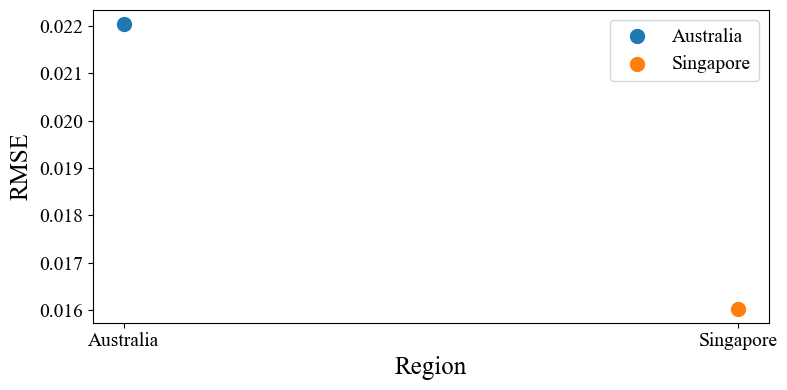

In [33]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Scatter plot of rmse values with markers and colors
for i, (region, values) in enumerate(rmse):
    ax.scatter(i, values, color=colors[i], marker='o', s=100, label=region)

ax.set_xticks(range(len(rmse)))
ax.set_xticklabels([region for region, _ in rmse])
ax.set_ylabel('RMSE', fontsize=18)
ax.set_xlabel('Region', fontsize=18)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.legend(fontsize=14)

plt.tight_layout()
plt.show()

<a id='Detrended-Fluctuation-Analysis'></a>
## Detrended Fluctuation Analysis
Furthermore, we also calculate the Hurst exponent value of power-grid frequency for each region. The values of the Hurst exponent of time series are estimated using the Detrended Fluctuation Analysis (DFA) method

Slope for Australia: [1.62361858]
Slope for Singapore: [1.83550564]


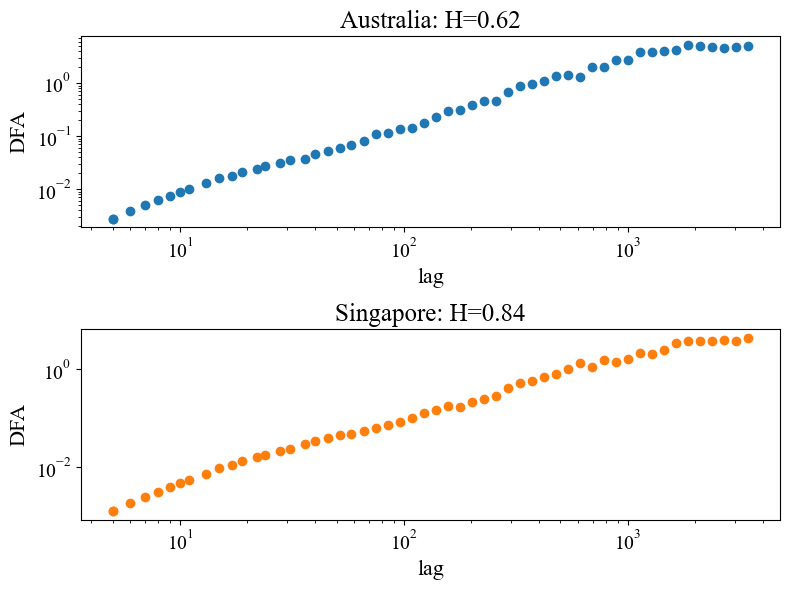

In [23]:
# Create a set of subplots based on the length of `filter_data`
fig, axs = plt.subplots(nrows=len(filter_data), figsize=(8, 6))

# Define parameters for MFDFA analysis
lag = np.logspace(0.7, 6, 100).astype(int)
q = 2
order = 1

for i, df in enumerate(filter_data):
    # Perform MFDFA analysis
    lag, dfa = MFDFA(df['f50'].dropna().values, lag=lag, q=q, order=order)
    
    # Plot the MFDFA results on the ith subplot
    axs[i].loglog(lag, dfa, 'o', label='fOU: MFDFA q=2', color=colors[i])
    
    # Perform linear fit to calculate Hurst exponent
    polyfit = np.polyfit(np.log(lag[:10]), np.log(dfa[:10]), 1)
    Hurst = polyfit[0] - 1
    
    # Set subplot title and labels for the ith subplot
    axs[i].set_title(f"{filter_dict[i]}: H={float(Hurst):.2f}", fontsize=18)
    axs[i].set_xlabel('lag', fontsize=16)
    axs[i].set_ylabel('DFA', fontsize=16)
    axs[i].tick_params(axis='y', labelsize=14)
    axs[i].tick_params(axis='x', labelsize=14)

    print(f"Slope for {filter_dict[i]}: {polyfit[0]}")

plt.rcParams.update({'font.family': 'Times New Roman'})
plt.tight_layout()
plt.show()


<a id='Chapman-Kolmogorov-(CK)-test'></a>
## Chapman-Kolmogorov (CK) test

If your time series is stationary, then you can use CK test to prove Markovianity, not the opposite. The test is based on the Chapman--Kolmogorov equation, which is a fundamental result in the theory of Markov processes.
This equation states that the conditional probability distribution of two states of a Markov stochastic process, separated by a fixed time interval, can be computed as the product of the conditional probability distributions of each state given the state at an intermediate time.

To quantify our results from the CK equation and validate our findings, we employ several approaches.
Firstly, we calculate the Bhattacharyya distance between $p(f_3, t_3 | f_1, t_1)$ and $p(f_3, t_3 | f_2, t_2;f_1, t_1 )$ for different sets of time intervals. 
This analysis allows us to investigate the long-time behavior. 
If the data follows a Markovian process, the distance between the distributions should be zero.

In [63]:
def CKtest (data, tau1, tau2, tau3, bins):
    
    # input
    # data: The input time series data for which you want to perform the conditional entropy calculation.
    # tau1: The lag value for the x3 time series.
    # tau2: The lag value for the x2 time series.
    # tau3: The lag value for the x1 time series.
    # bins: The number of bins used for constructing histograms.
    
    # output
    # x1: The bin edges for the x3 dimension.
    # x2: The bin edges for the x2 dimension.
    # p_1_2: The calculated conditional probability matrix for x1|x2.
    # p_1_23: The calculated conditional probability tensor for x1|x2,x3.
    
    # Extract data subsets based on tau values
    data1 = data[tau1:-tau1] # x3
    data2 = data[tau2:-tau2] # x2
    data3 = data[tau3:-tau3] # x1
    
     # Calculate bin width for each dimension
    dx1 = np.ptp(data3/(bins-1))  # the difference between max and min of data
    dx2 = np.ptp(data2)/(bins-1)
    dx3 = np.ptp(data1)/(bins-1)
    
    # Define bin edges for each dimension
    x1 = np.arange(min(data3), np.max(data3)+dx1, dx1)
    x2 = np.arange(min(data2), np.max(data2)+dx2, dx2)
    x3 = np.arange(min(data1), np.max(data1)+dx3, dx3)
    
    # Calculate differential areas for integration
    dA = dx1 * dx2
    dV = dx1 * dx2 * dx3
    
    # Finding 2D conditional PDF P(Xt|X(t-1)) or P(x1|x2)
    X = np.column_stack((data3[:len(data3)], data2[:len(data3)]))
    count, edges = np.histogramdd(X, bins=[x1, x2])
    p_12_ref = count/(len(X)*dA)  # Joint PDF of x1, x2
    
    # Calculate 1D PDF P(x2)
    p_2 = np.zeros(bins-1) # 1d PDF P(x2)
    for j in range(bins-1):
        p_2[j] = np.sum(p_12_ref[j,:]) * dx1
        
        # Initialize p_1_2
        p_1_2 = np.zeros((bins-1, bins-1))
        
    # Calculate conditional PDF p_1_2
    for j in range(bins-1):
        if p_2[j] > 0:
            p_1_2[:,j] = p_12_ref[:,j] / p_2[j]

            
    # Set values less than 1e-3 to zero
    p_1_2[p_1_2 < 1e-3] = 0
    
    #Finding 3D conditional PDF P(X_t|X_(t-1),X_(t-2)) or P(x1|x2,x3)
    Y = np.zeros((len(data3), 3))
    Y[:, 0] = data3[:len(data3)]
    Y[:, 1] = data2[:len(data3)]
    Y[:, 2] = data1[:len(data3)]


    edges = (x1, x2, x3)
    count, edges = np.histogramdd(Y, bins=edges)
    mid = [0.5 * (edges[i][1:] + edges[i][:-1]) for i in range(3)]
    loc = np.array(np.unravel_index(np.arange(bins ** 3), (bins, bins, bins)), order='F').T

    # calculate the joint PDF of x2 and x3
    p_123_ref = count / (len(Y) * dV) # % Conditional PDF P(x1|x2,x3)
    p_23 = np.zeros((bins-1, bins-1))
    for i in range(bins-1):
        for j in range(bins-1):
            p_23[i, j] = np.sum(p_123_ref[i, j, :]) * dx1
            
    # calculate the conditional PDF of x1 given x2 and x3
    p_1_23 = np.zeros((bins-1, bins-1, bins-1))
    for i in range(bins-1):
        for j in range(bins-1):
            if p_23[i, j] > 0:
                p_1_23[:, i, j] = p_123_ref[:, i, j] / p_23[i, j]

    # Return the calculated values
    return x1, x2, p_1_2,p_1_23

In [54]:
# Define tau value sets
tau_sets = [
    [2, 4, 6],
    [5,10, 15],
    [20, 40, 60],
    [30, 60, 90],
    [50, 100, 150],
    [70, 140, 210],
    [90, 180, 270],
    [100, 200, 300],
    [200, 400, 600],
    [300, 600, 900],
    [400, 800, 1200],
    [500, 1000, 1500],
    [600, 1200, 1800],
    [700, 1400, 2100],
    [800, 1600, 2400],
    [900, 1800, 2700],
    [1000, 2000, 3000]
    
]

In [64]:
# Please choose the appropriate tau set according to your data size
tau_sets = [
    [2, 4, 6],
    [5,10, 15],
    [20, 40, 60],
    [30, 60, 90],
    [50, 100, 150]
    
]

In [71]:
aus_distances=[]

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for filter_data[0]
    x1, x2, p_1_2, p_1_23 = CKtest(filter_data[0].f50.dropna().values, tau[0], tau[1], tau[2], 52)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    aus_distances.append(distance)

In [67]:
sgp_distances=[]

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for filter_data[1]
    x1, x2, p_1_2, p_1_23 = CKtest(filter_data[1].f50.dropna().values, tau[0], tau[1], tau[2], 51)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    sgp_distances.append(distance)

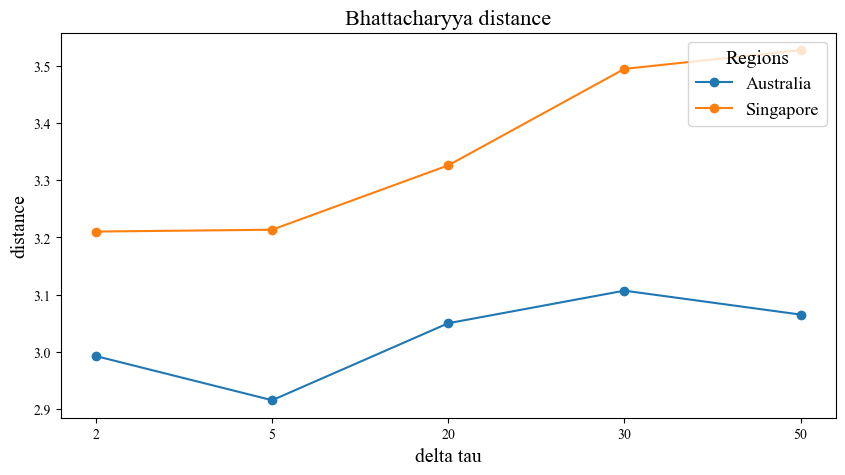

In [73]:
dis=[aus_distances,sgp_distances]


fig, ax = plt.subplots(figsize=(10,5))

for i, df in enumerate(dis):
    ax.plot(range(len(tau_sets)),df, 'o-',color=colors[i], label=region_dict[i])
    ax.set_title('Bhattacharyya distance',fontsize=16)
    ax.set_xlabel('delta tau',fontsize=14)
    ax.set_ylabel('distance',fontsize=14)

plt.xticks(range(len(tau_sets)),[2,5,20,30,50]) 
#plt.xticks(range(len(tau_sets)),[2,5,20,30,50,70,90,100,200,300,400,500,600,700,800,900,1000]) 
plt.legend(title = "Regions", title_fontsize=14, fontsize=13, loc='upper right')

plt.show()

In addition, to further explore the characteristics of the power-grid frequency, we employ three fractional Ornstein--Uhlenbeck process datasets.
These datasets are generated with varying Hurst exponents of 0.2, 0.5, and 0.8.

In [74]:
def generate_fractional_ou_process(H, t_final, delta_t, theta, sigma):
    # Time array
    time = np.linspace(0, t_final, int(t_final / delta_t) + 1)

    # Fractional Gaussian noise
    dB = (t_final ** H) * fgn(N=time.size, H=H)

    # Initialize the array
    y = np.zeros(time.size)
    y[0] = np.random.normal(size=1) / 10

    # Integrate the process
    for i in range(1, time.size):
        y[i] = y[i - 1] - theta * y[i - 1] * delta_t + sigma * dB[i]

    return time, y

In [75]:
fou2_distances=[]

time, process = generate_fractional_ou_process(H=0.2, t_final=500, delta_t=0.001, theta=0.3, sigma=0.1)

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for dataframe
    x1, x2, p_1_2, p_1_23 = CKtest(process, tau[0], tau[1], tau[2], 51)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    fou2_distances.append(distance)

In [76]:
fou5_distances=[]

time, process = generate_fractional_ou_process(H=0.5, t_final=700, delta_t=0.001, theta=0.3, sigma=0.1)

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for dataframe
    x1, x2, p_1_2, p_1_23 = CKtest(process, tau[0], tau[1], tau[2], 51)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    fou5_distances.append(distance)

In [77]:
fou8_distances=[]

time, process = generate_fractional_ou_process(H=0.8, t_final=900, delta_t=0.001, theta=0.3, sigma=0.1)

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for dataframe
    x1, x2, p_1_2, p_1_23 = CKtest(process, tau[0], tau[1], tau[2], 51)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    fou8_distances.append(distance)

In [78]:
fou_dis=[fou2_distances,fou5_distances,fou8_distances]
fou_dict=('hurst 0.2','hurst 0.5','hurst 0.8')
fou_colors=('#7fc97f', '#beaed4','#fdc086')

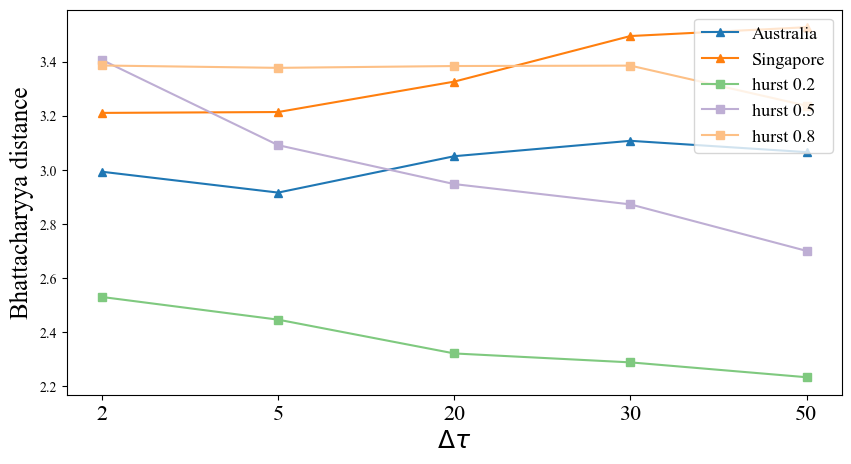

In [80]:
fig, ax = plt.subplots(figsize=(10,5))

# Plot Asia lines
for i, df in enumerate(dis):
    ax.plot(range(len(df)), df, '^-', color=colors[i], label=region_dict[i])

# Plot FBM lines
for i, df in enumerate(fou_dis):
    ax.plot(range(len(df)), df, 's-', color=fou_colors[i], label=fou_dict[i])

#ax.set_title('Bhattacharyya distance', fontsize=16)
ax.set_xlabel('$\u0394\u03C4$', fontsize=18)
ax.set_ylabel('Bhattacharyya distance', fontsize=18)
plt.xticks(range(len(tau_sets)), [2,5,20,30,50], fontsize=16)
#plt.xticks(range(len(tau_sets)), [2,5,20,30,50,70,90,100,200,300,400,500,600,700,800,900,1000], fontsize=16) 
plt.legend(fontsize=13, loc='upper right')

plt.rcParams.update({'font.family': 'Times New Roman'})
plt.show()

<a id='Rescaled-Range-Analysis-(R/S)'></a>
## Rescaled Range Analysis (R/S)
We also can use the R/S analysis to estimate the value of hurst exponents

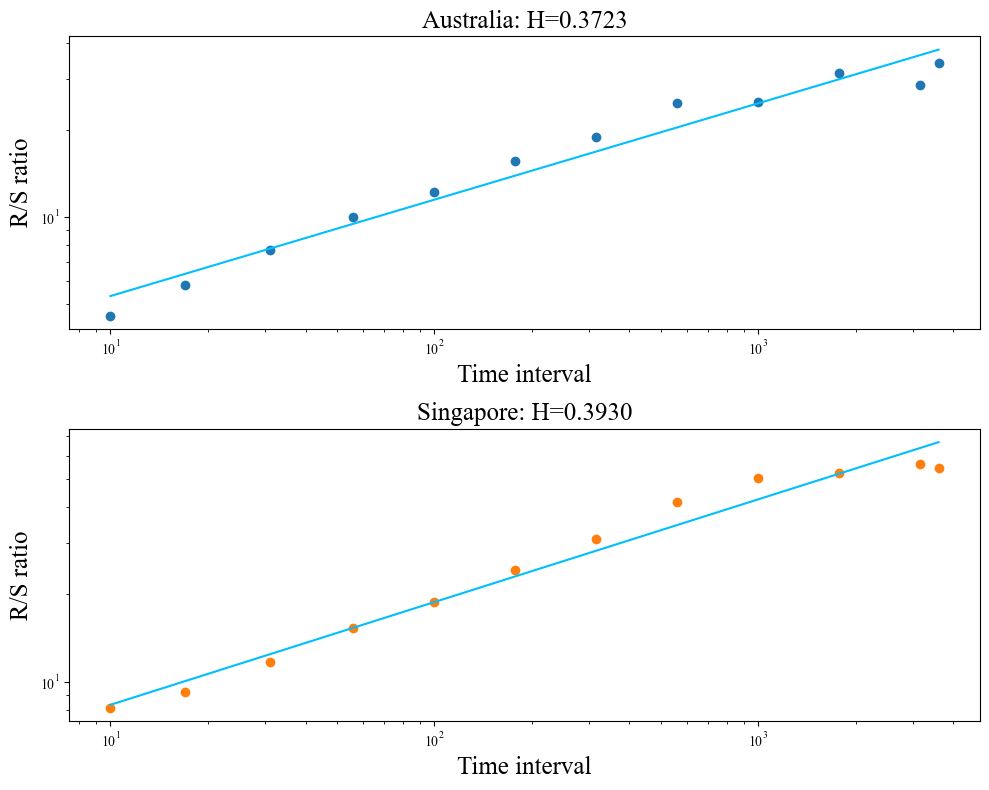

In [85]:
# Evaluate Hurst equation and plot for each region
fig, axes = plt.subplots(nrows=len(dataframes), figsize=(10, 8))

# Iterate through each region's data and corresponding subplot
for i, ax in enumerate(axes.flat):
    # Calculate the Hurst exponent (H) and the rescaled range (R/S) values
    H, c, data = compute_Hc(filter_data[i]['f50'].dropna().values, kind='price', simplified=True)
    
    # Plot the Hurst exponent line using the calculated values
    ax.plot(data[0], c * data[0]**H, color="deepskyblue")
    
    # Scatter plot the original R/S values
    ax.scatter(data[0], data[1], color=colors[i])
    
    # Fit a linear model to the logarithmic values of R/S
    np.polyfit(np.log(data[0]), np.log(data[1]), 1)
    
    # Fit a linear model to the logarithmic values of R/S for the first 10 data points
    H_new = np.polyfit(np.log(data[0])[:10], np.log(data[1])[:10], 1)[0]
    
    # Set the x and y scales to logarithmic
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Set labels and title for the subplot
    ax.set_xlabel('Time interval', fontsize=18)
    ax.set_ylabel('R/S ratio', fontsize=18)
    ax.set_title('{}: H={:.4f}'.format(region_dict[i], H_new), fontsize=18)

# Adjust layout and display the plot
fig.tight_layout()

# Set font family to Times New Roman for better readability
plt.rcParams.update({'font.family': 'Times New Roman'})

# Display the plot
plt.show()